# CMI – Detect Behavior with Sensor Data
### Classical ML Baseline (CSC 480 Project)

This notebook implements a full classical ML pipeline for the Kaggle competition
**"CMI – Detect Behavior with Sensor Data"**, following a course-style project:

- Use hand-crafted, orientation-robust features from wrist-worn sensor data.
- Treat this as supervised learning with:
  - Multiclass gesture prediction.
  - Binary Target vs Non-Target (BFRB-like vs non-BFRB) derived from gesture labels.
- Evaluate with a local implementation of the competition metric:
  - Binary F1 (Target vs Non-Target).
  - Macro F1 on gestures with all Non-Target gestures grouped together.
- Use subject aware cross-validation to avoid leakage.
- Train simple models within the course scope:
  - Logistic Regression (one-vs-rest).
  - k-Nearest Neighbors.
  - Decision Tree.
  - Gaussian Naive Bayes.


In [1]:
# Basic setup and imports

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
RANDOM_STATE = 42


## 1. Load data

By default this assumes the Kaggle competition input path:

`/kaggle/input/cmi-detect-behavior-with-sensor-data`



In [2]:
# Detect data directory: Kaggle first, then local ./data
kaggle_dir = Path("/kaggle/input/cmi-detect-behavior-with-sensor-data")
local_dir = Path("./data")

if (kaggle_dir / "train.csv").exists():
    DATA_DIR = kaggle_dir
elif (local_dir / "train.csv").exists():
    DATA_DIR = local_dir
else:
    raise FileNotFoundError(
        "Could not find train.csv. Put the competition data in "
        "/kaggle/input/cmi-detect-behavior-with-sensor-data or ./data."
    )

print(f"Using data from: {DATA_DIR.resolve()}")

train = pd.read_csv(DATA_DIR / "train.csv")
print("Train shape (long format, time steps):", train.shape)
train.head()


Using data from: /kaggle/input/cmi-detect-behavior-with-sensor-data
Train shape (long format, time steps): (574945, 341)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,...,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,110.0,87.0,126.0,-1.0,-1.0,-1.0,-1.0,-1.0,137.0,...,-1.0,-1.0,-1.0,122.0,121.0,140.0,164.0,-1.0,-1.0,-1.0,140.0,119.0,135.0,156.0,166.0,-1.0,-1.0,155.0,137.0,112.0,148.0,163.0,164.0,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,6.214844,3.125000,0.143494,-0.340271,-0.428650,-0.824524,29.340816,31.874645,29.791740,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,-1.0,-1.0,-1.0,-1.0,165.0,116.0,86.0,75.0,130.0,-1.0,-1.0,-1.0,-1.0,142.0,114.0,91.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,145.0,...,-1.0,-1.0,140.0,130.0,124.0,143.0,168.0,-1.0,-1.0,-1.0,142.0,122.0,138.0,157.0,-1.0,-1.0,-1.0,155.0,133.0,117.0,145.0,170.0,163.0,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,5.410156,5.421875,0.219055,-0.274231,-0.356934,-0.865662,30.339359,30.935045,30.090014,28.796087,28.529778,137.0,136.0,147.0,109.0,90.0,81.0,74.0,74.0,-1.0,164.0,165.0,146.0,106.0,94.0,77.0,77.0,-1.0,-1.0,-1.0,180.0,140.0,118.0,103.0,92.0,-1.0,-1.0,-1.0,-1.0,-1.0,155.0,119.0,122.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,148.0,...,-1.0,128.0,123.0,126.0,142.0,165.0,185.0,-1.0,-1.0,-1.0,145.0,139.0,138.0,164.0,-1.0,-1.0,-1.0,-1.0,145.0,120.0,151.0,165.0,-1.0,-1.0,-1.0,151.0,138.0,127.0,151.0,187.0,-1.0,156.0,136.0,135.0,134.0,-1.0,133.0,142.0,131.0,130.0,132.0,136.0,-1.0,-1.0,112.0,121.0,123.0,125.0,-1.0,-1.0,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,3.531250,6.457031,0.297546,-0.264160,-0.238159,-0.885986,30.543730,27.044001,29.310717,29.018711,27.402010,143.0,147.0,170.0,127.0,109.0,98.0,95.0,95.0,-1.0,177.0,189.0,177.0,136.0,121.0,107.0,104.0,-1.0,-1.0,-1.0,202.0,171.0,160.0,1

## 2. Quick EDA

The train file is a long-format time-series table. Typical columns include:

- `row_id` – unique row.
- `sequence_id` – ID for each short sequence.
- `sequence_counter` – time step index within a sequence.
- `subject` – person ID.
- `sequence_type` – "Target" or "Non-Target" (BFRB vs non-BFRB).
- `orientation`, `behavior`, `phase` – metadata.
- `gesture` – gesture label.
- Sensor channels:
  - IMU: e.g. `acc_x`, `acc_y`, `acc_z`, `gyro_x`, `gyro_y`, `gyro_z`, `rot_x`, `rot_y`, `rot_z`, `rot_w`.
  - Thermopile (THM): `thm_0`, ..., etc.
  - Time-of-flight (ToF): `tof_*_*`.


In [3]:
# Basic info
print(train.dtypes.head(20))

print("\nUnique gestures:", train["gesture"].nunique())
print(train["gesture"].value_counts().head(10))

if "sequence_type" in train.columns:
    print("\nSequence type counts (Target vs Non-Target):")
    print(train["sequence_type"].value_counts())

if "subject" in train.columns:
    print("\nNumber of subjects:", train["subject"].nunique())


row_id               object
sequence_type        object
sequence_id          object
sequence_counter      int64
subject              object
orientation          object
behavior             object
phase                object
gesture              object
acc_x               float64
acc_y               float64
acc_z               float64
rot_w               float64
rot_x               float64
rot_y               float64
rot_z               float64
thm_1               float64
thm_2               float64
thm_3               float64
thm_4               float64
dtype: object

Unique gestures: 18
gesture
Text on phone               58462
Neck - scratch              56619
Eyebrow - pull hair         44305
Forehead - scratch          40923
Forehead - pull hairline    40802
Above ear - pull hair       40560
Neck - pinch skin           40507
Eyelash - pull hair         40218
Cheek - pinch skin          40124
Wave hello                  34356
Name: count, dtype: int64

Sequence type counts (Target v

In [4]:
# Sequence-level summary: how many time steps per sequence?
if "sequence_counter" in train.columns:
    seq_lengths = train.groupby("sequence_id")["sequence_counter"].max() + 1  # assuming 0-based counter
else:
    # Fallback: count rows per sequence
    seq_lengths = train.groupby("sequence_id")["row_id"].count()

print("Number of sequences:", seq_lengths.shape[0])
seq_lengths.describe()


Number of sequences: 8151


count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
Name: sequence_counter, dtype: float64

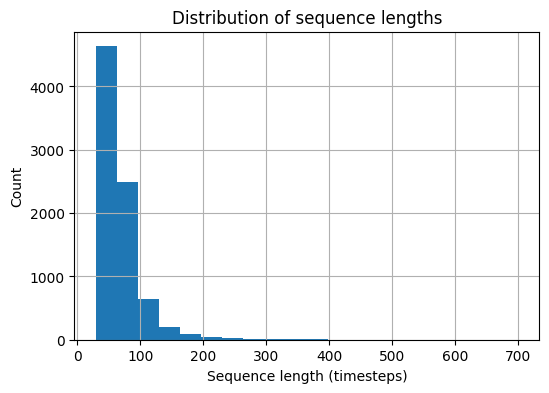

In [5]:
# Visualize distribution of sequence lengths
plt.figure(figsize=(6,4))
seq_lengths.hist(bins=20)
plt.xlabel("Sequence length (timesteps)")
plt.ylabel("Count")
plt.title("Distribution of sequence lengths")
plt.show()


### Inspect a single example sequence

We'll plot one IMU channel over time just to see how the data looks.


Example sequence: SEQ_000007
Length: 57
IMU columns present: ['acc_x', 'acc_y', 'acc_z']


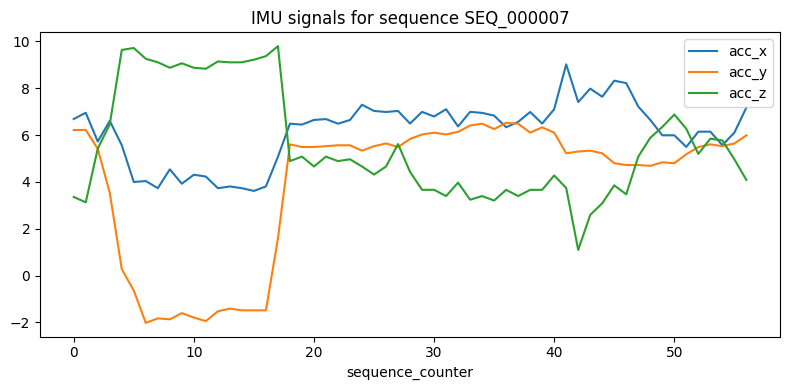

In [6]:
example_seq = train["sequence_id"].iloc[0]
example = train[train["sequence_id"] == example_seq].sort_values(
    "sequence_counter" if "sequence_counter" in train.columns else "row_id"
)

imu_cols = [c for c in ["acc_x", "acc_y", "acc_z"] if c in example.columns]
print("Example sequence:", example_seq)
print("Length:", example.shape[0])
print("IMU columns present:", imu_cols)

if imu_cols:
    plt.figure(figsize=(8,4))
    for c in imu_cols:
        plt.plot(
            example["sequence_counter"] if "sequence_counter" in example.columns else np.arange(len(example)),
            example[c],
            label=c
        )
    plt.title(f"IMU signals for sequence {example_seq}")
    plt.xlabel("sequence_counter")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 3. Define Target (BFRB) vs Non-Target and the metric

The official competition metric averages:

1. Binary F1 for Target vs Non-Target (BFRB vs non-BFRB).
2. Macro F1 across gesture labels, after collapsing all Non-Target gestures
   into a single "Non-Target" class.

We implement a local approximation of this metric for cross-validation.


In [7]:
# Example list of BFRB-like target gestures.
# These strings should match values in the 'gesture' column if the dataset uses text labels.
TARGET_GESTURES = [
    "Above ear - pull hair",
    "Cheek - pinch skin",
    "Eyebrow - pull hair",
    "Eyelash - pull hair",
    "Forehead - pull hairline",
    "Forehead - scratch",
    "Neck - pinch skin",
    "Neck - scratch",
]

# Keep only those actually present (in case labels differ)
TARGET_GESTURES = [g for g in TARGET_GESTURES if g in train["gesture"].unique()]
print("Target gestures actually present in this train file:")
print(TARGET_GESTURES)


Target gestures actually present in this train file:
['Above ear - pull hair', 'Cheek - pinch skin', 'Eyebrow - pull hair', 'Eyelash - pull hair', 'Forehead - pull hairline', 'Forehead - scratch', 'Neck - pinch skin', 'Neck - scratch']


In [8]:
def cmi_2025_score(y_true_gesture, y_pred_gesture):
    """
    Local approximation of the competition metric.

    Steps:
      1. Binary F1: Target vs Non-Target
         - Positive class = BFRB-like gestures.
      2. Macro F1: gestures with all non-targets collapsed into one class "Non-Target".
      3. Final score = (Binary F1 + Macro F1) / 2.
    """
    y_true_gesture = pd.Series(y_true_gesture).astype(str)
    y_pred_gesture = pd.Series(y_pred_gesture).astype(str)

    # 1) Binary F1: Target vs Non-Target
    true_is_target = y_true_gesture.isin(TARGET_GESTURES)
    pred_is_target = y_pred_gesture.isin(TARGET_GESTURES)

    f1_bin = f1_score(true_is_target, pred_is_target, average="binary")

    # 2) Macro F1: gestures with non-targets collapsed
    def collapse_non_target(series):
        return series.apply(lambda g: g if g in TARGET_GESTURES else "Non-Target")

    y_true_mc = collapse_non_target(y_true_gesture)
    y_pred_mc = collapse_non_target(y_pred_gesture)
    f1_macro = f1_score(y_true_mc, y_pred_mc, average="macro")

    return f1_bin, f1_macro, 0.5 * (f1_bin + f1_macro)

# Tiny sanity check: perfect prediction → perfect scores
tmp = train.groupby("sequence_id")["gesture"].first()
f1b, f1m, score = cmi_2025_score(tmp, tmp)
print("Sanity check (perfect predictions on themselves):")
print(f"Binary F1: {f1b:.3f}, Macro F1: {f1m:.3f}, Score: {score:.3f}")


Sanity check (perfect predictions on themselves):
Binary F1: 1.000, Macro F1: 1.000, Score: 1.000


## 4. Feature engineering

We build sequence-level features using:

- IMU magnitudes for orientation robustness:
  - `acc_mag = sqrt(acc_x² + acc_y² + acc_z²)`.
  - `gyro_mag = sqrt(gyro_x² + gyro_y² + gyro_z²)` (if present).
- For each numeric sensor channel, compute statistics over multiple overlapping windows:
  - Window 0: full sequence (0–100%).
  - Window 1: early half (0–50%).
  - Window 2: late half (50–100%).
- Statistics per `(sensor, window)` pair:
  - mean.
  - standard deviation.
  - range = max − min.
  - IQR = Q3 − Q1.
  - simple difference = last − first.

This yields one feature vector per sequence.


In [9]:
# Identify meta columns and numeric sensor columns

META_COLS = [
    "row_id",
    "sequence_id",
    "sequence_counter",
    "subject",
    "sequence_type",
    "orientation",
    "behavior",
    "phase",
    "gesture",
]

meta_existing = [c for c in META_COLS if c in train.columns]

numeric_cols = [
    c for c in train.columns
    if c not in meta_existing and np.issubdtype(train[c].dtype, np.number)
]

print("Meta columns found:", meta_existing)
print("\nNumber of numeric sensor columns:", len(numeric_cols))
print(numeric_cols[:20])


Meta columns found: ['row_id', 'sequence_id', 'sequence_counter', 'subject', 'sequence_type', 'orientation', 'behavior', 'phase', 'gesture']

Number of numeric sensor columns: 332
['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7']


In [10]:
def add_magnitude_columns(df, inplace=False):
    """
    Adds orientation-robust magnitude columns for IMU channels if all components are present.
    - acc_mag: from acc_x, acc_y, acc_z
    - gyro_mag: from gyro_x, gyro_y, gyro_z
    """
    if not inplace:
        df = df.copy()

    # Accelerometer magnitude
    acc_axes = ["acc_x", "acc_y", "acc_z"]
    if all(a in df.columns for a in acc_axes):
        df["acc_mag"] = np.sqrt((df[acc_axes] ** 2).sum(axis=1))

    # Gyro magnitude
    gyro_axes = ["gyro_x", "gyro_y", "gyro_z"]
    if all(a in df.columns for a in gyro_axes):
        df["gyro_mag"] = np.sqrt((df[gyro_axes] ** 2).sum(axis=1))

    return df

# Add magnitudes to train
train = add_magnitude_columns(train, inplace=True)

# Update numeric columns after adding magnitudes
numeric_cols = [
    c for c in train.columns
    if c not in meta_existing and np.issubdtype(train[c].dtype, np.number)
]
print("Numeric sensor columns including magnitudes:", len(numeric_cols))


Numeric sensor columns including magnitudes: 333


In [11]:
WINDOW_FRACS = [
    (0.0, 1.0),  # full sequence
    (0.0, 0.5),  # early half
    (0.5, 1.0),  # late half
]

def _window_indices(n, start_frac, end_frac):
    """Convert fractional window to integer indices [start, end)."""
    start = int(np.floor(start_frac * n))
    end = int(np.ceil(end_frac * n))
    start = max(0, min(start, n - 1))
    end = max(start + 1, min(end, n))
    return start, end

def _window_stats(arr):
    """Compute simple stats on a 1D numpy array (may contain NaN)."""
    if arr.size == 0:
        return {
            "mean": np.nan,
            "std": np.nan,
            "range": np.nan,
            "iqr": np.nan,
            "diff": np.nan,
        }

    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    minv = np.nanmin(arr)
    maxv = np.nanmax(arr)
    rang = maxv - minv
    q25 = np.nanpercentile(arr, 25)
    q75 = np.nanpercentile(arr, 75)
    iqr = q75 - q25
    diff = arr[-1] - arr[0]

    return {
        "mean": mean,
        "std": std,
        "range": rang,
        "iqr": iqr,
        "diff": diff,
    }

def build_sequence_features(df, window_fracs=WINDOW_FRACS, sensor_cols=None):
    """
    Turn long-format time-series into one row per sequence_id.
    For each numeric sensor column:
      - compute basic stats over multiple windows.
    Keeps non-leaky metadata (sequence_id, subject, sequence_type, gesture).
    """
    if sensor_cols is None:
        sensor_cols_local = [
            c for c in df.columns
            if c not in META_COLS and np.issubdtype(df[c].dtype, np.number)
        ]
    else:
        sensor_cols_local = sensor_cols

    # Make sure magnitudes exist
    df = add_magnitude_columns(df, inplace=False)

    feature_rows = []

    seq_group = df.groupby("sequence_id", sort=False)
    for seq_id, g in seq_group:
        g = g.sort_values(
            by=["sequence_counter"] if "sequence_counter" in g.columns else g.columns[0:1]
        )
        n = g.shape[0]

        row = {
            "sequence_id": seq_id
        }
        # Copy non-leaky metadata: subject & sequence_type & gesture (for labels)
        if "subject" in g.columns:
            row["subject"] = g["subject"].iloc[0]
        if "sequence_type" in g.columns:
            row["sequence_type"] = g["sequence_type"].iloc[0]
        if "gesture" in g.columns:
            row["gesture"] = g["gesture"].iloc[0]

        for col in sensor_cols_local:
            values = g[col].to_numpy()
            for w_idx, (s_frac, e_frac) in enumerate(window_fracs):
                s, e = _window_indices(n, s_frac, e_frac)
                window_vals = values[s:e]
                stats = _window_stats(window_vals)
                for stat_name, stat_val in stats.items():
                    feat_name = f"{col}__w{w_idx}__{stat_name}"
                    row[feat_name] = stat_val

        feature_rows.append(row)

    features = pd.DataFrame(feature_rows)
    return features

seq_features = build_sequence_features(train, window_fracs=WINDOW_FRACS, sensor_cols=numeric_cols)

print("Sequence-level feature table shape:", seq_features.shape)
seq_features.head()


Sequence-level feature table shape: (8151, 4999)


,sequence_id,subject,sequence_type,gesture,acc_x__w0__mean,acc_x__w0__std,acc_x__w0__range,acc_x__w0__iqr,acc_x__w0__diff,acc_x__w1__mean,acc_x__w1__std,acc_x__w1__range,acc_x__w1__iqr,acc_x__w1__diff,acc_x__w2__mean,acc_x__w2__std,acc_x__w2__range,acc_x__w2__iqr,acc_x__w2__diff,acc_y__w0__mean,acc_y__w0__std,acc_y__w0__range,acc_y__w0__iqr,acc_y__w0__diff,acc_y__w1__mean,acc_y__w1__std,acc_y__w1__range,acc_y__w1__iqr,acc_y__w1__diff,acc_y__w2__mean,acc_y__w2__std,acc_y__w2__range,acc_y__w2__iqr,acc_y__w2__diff,acc_z__w0__mean,acc_z__w0__std,acc_z__w0__range,acc_z__w0__iqr,acc_z__w0__diff,acc_z__w1__mean,acc_z__w1__std,acc_z__w1__range,acc_z__w1__iqr,acc_z__w1__diff,acc_z__w2__mean,acc_z__w2__std,acc_z__w2__range,acc_z__w2__iqr,acc_z__w2__diff,rot_w__w0__mean,rot_w__w0__std,rot_w__w0__range,rot_w__w0__iqr,rot_w__w0__diff,rot_w__w1__mean,rot_w__w1__std,rot_w__w1__range,rot_w__w1__iqr,rot_w__w1__diff,rot_w__w2__mean,...,tof_5_v61__w0__mean,tof_5_v61__w0__std,tof_5_v61__w0__range,tof_5_v61__w0__iqr,tof_5_v61__w0__diff,tof_5_v61__w1__mean,tof_5_v61__w1__std,tof_5_v61__w1__range,tof_5_v61__w1__iqr,tof_5_v61__w1__diff,tof_5_v61__w2__mean,tof_5_v61__w2__std,tof_5_v61__w2__range,tof_5_v61__w2__iqr,tof_5_v61__w2__diff,tof_5_v62__w0__mean,tof_5_v62__w0__std,tof_5_v62__w0__range,tof_5_v62__w0__iqr,tof_5_v62__w0__diff,tof_5_v62__w1__mean,tof_5_v62__w1__std,tof_5_v62__w1__range,tof_5_v62__w1__iqr,tof_5_v62__w1__diff,tof_5_v62__w2__mean,tof_5_v62__w2__std,tof_5_v62__w2__range,tof_5_v62__w2__iqr,tof_5_v62__w2__diff,tof_5_v63__w0__mean,tof_5_v63__w0__std,tof_5_v63__w0__range,tof_5_v63__w0__iqr,tof_5_v63__w0__diff,tof_5_v63__w1__mean,tof_5_v63__w1__std,tof_5_v63__w1__range,tof_5_v63__w1__iqr,tof_5_v63__w1__diff,tof_5_v63__w2__mean,tof_5_v63__w2__std,tof_5_v63__w2__range,tof_5_v63__w2__iqr,tof_5_v63__w2__diff,acc_mag__w0__mean,acc_mag__w0__std,acc_mag__w0__range,acc_mag__w0__iqr,acc_mag__w0__diff,acc_mag__w1__mean,acc_mag__w1__std,acc_mag__w1__range,acc_mag__w1__iqr,acc_mag__w1__diff,acc_mag__w2__mean,acc_mag__w2__std,acc_mag__w2__range,acc_mag__w2__iqr,acc_mag__w2__diff
0,SEQ_000007,SUBJ_059520,Target,Cheek - pinch skin,6.153098,1.322400,5.402344,1.421875,0.488281,5.456088,1.343859,3.679688,2.648438,-0.195312,6.861665,0.804492,3.523438,0.839844,0.683594,3.915570,3.021429,8.539062,2.453125,-0.230469,2.247845,3.452762,8.234375,7.007812,-0.382812,5.649380,0.600795,1.835938,0.882812,0.152344,5.577782,2.316922,8.699219,3.214844,0.726562,6.918508,2.302610,6.667969,4.218750,1.070312,4.197333,1.261630,5.781250,1.683594,-0.343750,0.263574,0.068424,0.244873,0.112610,0.108765,0.297117,0.070642,0.244873,0.115173,0.082275,0.228415,...,51.877193,48.686995,115.0,98.00,99.0,36.758621,44.965623,94.0,91.0,94.0,68.413793,46.834645,115.0,101.0,5.0,55.947368,51.747505,227.0,96.0,97.0,40.172414,54.911257,227.0,87.0,90.0,72.862069,41.841840,107.0,9.0,7.0,41.192982,46.163492,100.0,93.00,95.0,29.586207,42.218248,94.0,85.0,94.0,54.586207,46.741045,100.0,95.0,1.0,10.021660,0.340875,1.969136,0.282919,0.469818,10.079296,0.353261,1.578918,0.264875,0.058650,9.955778,0.312891,1.896675,0.306199,0.411168
1,SEQ_000008,SUBJ_020948,Target,Forehead - pull hairline,3.400506,1.079119,4.171875,1.877930,-0.917969,3.311466,1.323067,4.019531,2.443359,1.496094,3.489545,0.750088,3.214844,0.720703,-2.949219,5.311179,3.243954,8.890625,7.238281,4.941406,3.344554,3.558528,8.199219,7.494141,8.042969,7.277803,0.805065,3.949219,1.063477,-3.101562,6.581629,2.457134,9.351562,5.120117,-4.593750,7.552275,2.700726,7.898438,5.383789,-5.289062,5.610983,1.701994,7.277344,2.395508,0.656250,0.243493,0.063939,0.184387,0.124420,-0.013672,0.259166,0.083057,0.184387,0.171661,-0.161499,0.227821,...,-1.000000,0.000000,0.0,0.00,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.00,0.0,-1.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.0,0.0,10.018998,0.659414,4.415483,0.518329

We now have one row per sequence with derived features.

Next steps:

- Define `X` (features), `y` (gesture labels), and `groups` (subject).
- Use subject-aware cross-validation.
- Evaluate each model with the local competition metric.


In [12]:
# Prepare data for modeling

# Labels
y_gesture = seq_features["gesture"].astype(str)

# Groups (subject-aware CV)
if "subject" in seq_features.columns:
    groups = seq_features["subject"].astype(str)
else:
    # Fallback: group by sequence_id (less ideal)
    print("WARNING: subject column not found. Grouping by sequence_id instead.")
    groups = seq_features["sequence_id"].astype(str)

# Features: drop metadata
feature_cols = [
    c for c in seq_features.columns
    if c not in ["sequence_id", "subject", "sequence_type", "gesture"]
]
X = seq_features[feature_cols].values

print("Number of sequences:", X.shape[0])
print("Number of features:", X.shape[1])


Number of sequences: 8151
Number of features: 4995


## 5. Cross-validation setup

We use:

- `StratifiedGroupKFold` (if available) with:
  - stratification on gesture labels.
  - grouping on subject.
- Otherwise fall back to `GroupKFold` (no stratification).


In [13]:
def make_cv(n_splits=5, random_state=RANDOM_STATE):
    try:
        cv = StratifiedGroupKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=random_state
        )
        print("Using StratifiedGroupKFold.")
        return cv
    except Exception as e:
        print("Falling back to GroupKFold. (Reason:", e, ")")
        return GroupKFold(n_splits=n_splits)

cv = make_cv(n_splits=5)


Using StratifiedGroupKFold.


## 6. Define baseline models

We include four simple models:

- Logistic Regression (one-vs-rest).
- k-Nearest Neighbors.
- Decision Tree.
- Gaussian Naive Bayes.

Each wrapped in a pipeline with:

1. `SimpleImputer(strategy="median")` to handle missing sensors.
2. `StandardScaler()` for feature scaling (except the tree, which does not strictly need it).


In [14]:
def make_logreg():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            multi_class="ovr",
            max_iter=500,
            n_jobs=-1,
            random_state=RANDOM_STATE
        )),
    ])

def make_knn():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(
            n_neighbors=15,
            weights="distance",
            n_jobs=-1
        )),
    ])

def make_decision_tree():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            max_depth=8,
            min_samples_leaf=10,
            random_state=RANDOM_STATE
        )),
    ])

def make_gaussian_nb():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GaussianNB()),
    ])

models = {
    "LogisticRegression_OvR": make_logreg(),
    "KNN": make_knn(),
    "DecisionTree": make_decision_tree(),
    "GaussianNB": make_gaussian_nb(),
}
list(models.keys())


['LogisticRegression_OvR', 'KNN', 'DecisionTree', 'GaussianNB']

## 7. Cross-validation evaluation

For each model:

- Run cross-validation.
- For each fold:
  - Fit on training sequences.
  - Predict gestures on validation sequences.
  - Compute Binary F1, Macro F1, and combined score.
- Report per-fold and overall mean / std.


In [15]:
def evaluate_model(name, pipeline, X, y_gesture, groups, cv):
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y_gesture, groups), start=1):
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y_gesture.iloc[train_idx], y_gesture.iloc[val_idx]

        print(f"\n[{name}] Fold {fold_idx}: train={len(train_idx)}, val={len(val_idx)}")

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_va)

        f1_bin, f1_macro, score = cmi_2025_score(y_va, y_pred)
        print(f"  Binary F1 (Target vs Non-Target): {f1_bin:.4f}")
        print(f"  Macro F1 (gestures, Non-Target grouped): {f1_macro:.4f}")
        print(f"  Combined score (mean of both): {score:.4f}")

        fold_results.append({
            "fold": fold_idx,
            "f1_binary": f1_bin,
            "f1_macro": f1_macro,
            "cmi_score": score,
        })

    fold_df = pd.DataFrame(fold_results)
    summary = fold_df[["f1_binary", "f1_macro", "cmi_score"]].agg(["mean", "std"])
    print(f"\n[{name}] Cross-validation summary:")
    print(summary)

    return fold_df, summary


In [16]:
all_results = {}
all_summaries = {}

for name, model in models.items():
    print("\n" + "="*80)
    print(f"Evaluating model: {name}")
    print("="*80)
    fold_df, summary = evaluate_model(name, model, X, y_gesture, groups, cv)
    all_results[name] = fold_df
    all_summaries[name] = summary



Evaluating model: LogisticRegression_OvR

[LogisticRegression_OvR] Fold 1: train=6623, val=1528


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

  Binary F1 (Target vs Non-Target): 0.9344
  Macro F1 (gestures, Non-Target grouped): 0.4483
  Combined score (mean of both): 0.6913

[LogisticRegression_OvR] Fold 2: train=6519, val=1632


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Binary F1 (Target vs Non-Target): 0.9165
  Macro F1 (gestures, Non-Target grouped): 0.3901
  Combined score (mean of both): 0.6533

[LogisticRegression_OvR] Fold 3: train=6526, val=1625
  Binary F1 (Target vs Non-Target): 0.9130
  Macro F1 (gestures, Non-Target grouped): 0.4188
  Combined score (mean of both): 0.6659

[LogisticRegression_OvR] Fold 4: train=6519, val=1632
  Binary F1 (Target vs Non-Target): 0.8965
  Macro F1 (gestures, Non-Target grouped): 0.3935
  Combined score (mean of both): 0.6450

[LogisticRegression_OvR] Fold 5: train=6417, val=1734
  Binary F1 (Target vs Non-Target): 0.9080
  Macro F1 (gestures, Non-Target grouped): 0.4120
  Combined score (mean of both): 0.6600

[LogisticRegression_OvR] Cross-validation summary:
      f1_binary  f1_macro  cmi_score
mean   0.913664  0.412532   0.663098
std    0.013814  0.023343   0.017581

Evaluating model: KNN

[KNN] Fold 1: train=6623, val=1528
  Binary F1 (Target vs Non-Target): 0.9102
  Macro F1 (gestures, Non-Target group

## 8. Compare models

Collect mean scores for each model to see which baseline performs best.


In [17]:
summary_rows = []
for name, summary in all_summaries.items():
    summary_rows.append({
        "model": name,
        "f1_binary_mean": summary.loc["mean", "f1_binary"],
        "f1_binary_std": summary.loc["std", "f1_binary"],
        "f1_macro_mean": summary.loc["mean", "f1_macro"],
        "f1_macro_std": summary.loc["std", "f1_macro"],
        "cmi_mean": summary.loc["mean", "cmi_score"],
        "cmi_std": summary.loc["std", "cmi_score"],
    })

summary_table = pd.DataFrame(summary_rows).sort_values("cmi_mean", ascending=False)
summary_table


,model,f1_binary_mean,f1_binary_std,f1_macro_mean,f1_macro_std,cmi_mean,cmi_std
0,LogisticRegression_OvR,0.913664,0.013814,0.412532,0.023343,0.663098,0.017581
2,DecisionTree,0.895554,0.024729,0.384070,0.036359,0.639812,0.029219
1,KNN,0.874781,0.021220,0.353251,0.026470,0.614016,0.022527
3,GaussianNB,0.836363,0.037182,0.360390,0.039455,0.598377,0.034687


## 9. Fit final model on all training sequences

Pick the best-performing model (by mean combined score) and refit it on all sequences.

In the actual Kaggle competition the test predictions are produced via a special evaluation
API that streams sequences one by one. Here we show a simple pattern for training a final
model and making predictions for a new sequence. We did not use this for obvious reasons. 


In [19]:
# Pick best model by mean combined score
best_name = summary_table.iloc[0]["model"]
print("Best model by CV score:", best_name)

best_model = models[best_name]

# Refit on all sequence-level data
best_model.fit(X, y_gesture)

print("Best model refit on all training sequences.")


Best model by CV score: LogisticRegression_OvR
Best model refit on all training sequences.


### 10. Example: prediction on a new sequence

Below is a helper that demonstrates this for one sequence from the training set.


In [20]:
def predict_gesture_for_sequence(raw_df_one_sequence, trained_model=best_model):
    """
    raw_df_one_sequence: long-format dataframe for a single sequence_id.
    Returns: predicted gesture label.
    """
    # Build features for this sequence only
    feat_df = build_sequence_features(
        raw_df_one_sequence,
        window_fracs=WINDOW_FRACS,
        sensor_cols=numeric_cols,
    )
    X_seq = feat_df[feature_cols].values
    pred = trained_model.predict(X_seq)[0]
    return pred

# Example usage on an existing sequence from train (sanity check)
example_seq_id = seq_features["sequence_id"].iloc[0]
raw_example_seq = train[train["sequence_id"] == example_seq_id]
print("Example sequence_id:", example_seq_id)
print("Predicted gesture:", predict_gesture_for_sequence(raw_example_seq))
print("True gesture:", seq_features.loc[seq_features["sequence_id"] == example_seq_id, "gesture"].iloc[0])


Example sequence_id: SEQ_000007
Predicted gesture: Cheek - pinch skin
True gesture: Cheek - pinch skin


## 11. Simple error analysis

Inspect one fold predictions for the best model and print a classification report
for gesture labels.


In [21]:
# Get the first fold of the best model for a quick classification report
best_results = all_results[best_name]
first_fold = int(best_results["fold"].iloc[0])

# Rebuild the data split exactly as in that fold
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y_gesture, groups), start=1):
    if fold_idx == first_fold:
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y_gesture.iloc[train_idx], y_gesture.iloc[val_idx]
        break

best_model_fold = models[best_name]
best_model_fold.fit(X_tr, y_tr)
y_pred_va = best_model_fold.predict(X_va)

print(f"\nClassification report for {best_name} (fold {first_fold}):\n")
print(classification_report(y_va, y_pred_va, zero_division=0))



Classification report for LogisticRegression_OvR (fold 1):

                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.52      0.57      0.54       120
                        Cheek - pinch skin       0.32      0.32      0.32       120
                     Drink from bottle/cup       0.88      0.90      0.89        31
                       Eyebrow - pull hair       0.26      0.28      0.27       120
                       Eyelash - pull hair       0.30      0.27      0.28       120
Feel around in tray and pull out an object       0.88      0.97      0.92        31
                  Forehead - pull hairline       0.46      0.50      0.48       120
                        Forehead - scratch       0.57      0.59      0.58       120
                            Glasses on/off       0.92      0.77      0.84        31
                         Neck - pinch skin       0.28      0.33      0.30       120
              

## 12. Summary & Next Steps

This notebook:

- Builds orientation-robust sequence-level features from wrist sensor data.
- Implements a local approximation of the competition metric.
- Uses subject aware cross-validation to avoid leakage.
- Trains and compares four simple classical models.
- Selects the best model and demonstrates how to use it for sequence level prediction.

Possible extensions:

- Add slightly richer features (e.g., velocity / jerk or simple frequency-domain stats).
- Incorporate class weighting or alternative thresholds.
- Build a two-stage pipeline: Target vs Non-Target first, then gesture classification.
- Experiment with other classical models (e.g., Random Forest, Gradient Boosting) if allowed.


## 13. Novel Contributions 

1. **Orientation-robust IMU feature design**  
   - Instead of using raw `(acc_x, acc_y, acc_z)` and `(gyro_x, gyro_y, gyro_z)` directly, we build
     magnitude channels (`acc_mag`, `gyro_mag`) and extract statistics from them.  
   - This reduces sensitivity to arbitrary arm orientation and focuses on movement intensity.

2. **Multi-window temporal summarization of sequences**  
   - Rather than summarizing each sequence with a single global statistic, we compute features over
     multiple overlapping windows (full sequence, early half, late half).  
   - This captures how behavior evolves within a sequence (onset vs offset), which is particularly
     relevant to differentiating similar gestures.

3. **Subject-aware model selection with a custom competition metric**  
   - We implement a local approximation of the competition’s metric (binary F1 for Target vs
     Non-Target plus macro F1 over collapsed gestures) and use it **inside a subject-aware CV loop**
     (`StratifiedGroupKFold` / `GroupKFold`) for model selection.  
   - This is stricter and more realistic than random CV, and directly aligned with how the Kaggle
     leaderboard is scored.



## 14. Ablation Study (code scaffold)

1. **No IMU magnitudes**: remove `acc_mag` / `gyro_mag` features and only use raw axes.  
2. **Single-window features only**: summarize each sensor using a single full-sequence window instead of
   multiple windows.  




In [26]:
# ============================================================
# Ablation helper + two example ablations
# (place this AFTER best_name, models, cv, evaluate_model, etc.)
# ============================================================

def run_ablation_variant(desc, window_fracs, use_magnitudes):
    """
    Rebuild features under a specific configuration and evaluate the current
    best model under subject-aware CV.

    Parameters
    ----------
    desc : str
        Description of the ablation (for printing).
    window_fracs : list of (float, float)
        Window configuration to pass into build_sequence_features.
    use_magnitudes : bool
        If False, do NOT include acc_mag / gyro_mag in the sensor columns.
    """
    print("\n=== Ablation:", desc, "===")
    df = train.copy()

    # Decide which numeric columns to use
    if use_magnitudes:
        df = add_magnitude_columns(df, inplace=False)
        sensor_cols_variant = [
            c for c in df.columns
            if c not in META_COLS
            and np.issubdtype(df[c].dtype, np.number)
        ]
    else:
        # Do NOT use magnitude columns even if they exist
        sensor_cols_variant = [
            c for c in df.columns
            if c not in META_COLS
            and np.issubdtype(df[c].dtype, np.number)
            and not c.endswith("_mag")
        ]

    # Build sequence-level features for this variant
    seq_feat_var = build_sequence_features(
        df,
        window_fracs=window_fracs,
        sensor_cols=sensor_cols_variant,
    )

    # Labels and groups
    y_var = seq_feat_var["gesture"].astype(str)
    if "subject" in seq_feat_var.columns:
        groups_var = seq_feat_var["subject"].astype(str)
    else:
        groups_var = seq_feat_var["sequence_id"].astype(str)

    # Feature matrix
    feature_cols_var = [
        c for c in seq_feat_var.columns
        if c not in ["sequence_id", "subject", "sequence_type", "gesture"]
    ]
    X_var = seq_feat_var[feature_cols_var].values

    print("  #sequences:", X_var.shape[0], "| #features:", X_var.shape[1])

    # Evaluate using the same best model and CV object
    model = models[best_name]
    fold_df, summary = evaluate_model(
        best_name + " (ablation: " + desc + ")",
        model,
        X_var,
        y_var,
        groups_var,
        cv,
    )
    return fold_df, summary


# ============================
# Run two standard ablations
# ============================

# 1) Remove magnitudes but keep multi-window features
fold_no_mag, summ_no_mag = run_ablation_variant(
    desc="No IMU magnitudes (raw axes only)",
    window_fracs=WINDOW_FRACS,   # same multi-window config as main model
    use_magnitudes=False,
)
print("\nAblation 1 summary (no magnitudes):")
print(summ_no_mag)

# 2) Keep magnitudes but use a single full-window only
fold_single_win, summ_single_win = run_ablation_variant(
    desc="Single full-window only (no early/late splits)",
    window_fracs=[(0.0, 1.0)],   # one window over entire sequence
    use_magnitudes=True,
)
print("\nAblation 2 summary (single window only):")
print(summ_single_win)



=== Ablation: No IMU magnitudes (raw axes only) ===
  #sequences: 8151 | #features: 4980

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Fold 1: train=6623, val=1528


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

  Binary F1 (Target vs Non-Target): 0.9298
  Macro F1 (gestures, Non-Target grouped): 0.4419
  Combined score (mean of both): 0.6859

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Fold 2: train=6519, val=1632
  Binary F1 (Target vs Non-Target): 0.9134
  Macro F1 (gestures, Non-Target grouped): 0.3794
  Combined score (mean of both): 0.6464

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Fold 3: train=6526, val=1625


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Binary F1 (Target vs Non-Target): 0.9123
  Macro F1 (gestures, Non-Target grouped): 0.4126
  Combined score (mean of both): 0.6625

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Fold 4: train=6519, val=1632
  Binary F1 (Target vs Non-Target): 0.8911
  Macro F1 (gestures, Non-Target grouped): 0.3895
  Combined score (mean of both): 0.6403

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Fold 5: train=6417, val=1734
  Binary F1 (Target vs Non-Target): 0.9004
  Macro F1 (gestures, Non-Target grouped): 0.4032
  Combined score (mean of both): 0.6518

[LogisticRegression_OvR (ablation: No IMU magnitudes (raw axes only))] Cross-validation summary:
      f1_binary  f1_macro  cmi_score
mean   0.909406  0.405315   0.657360
std    0.014627  0.024088   0.017891

Ablation 1 summary (no magnitudes):
      f1_binary  f1_macro  cmi_score
mean   0.909406  0.405315   0.657360
std    0.014627  0.024088   0.017891

=== Ablation: Single full-window only (no

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

  Binary F1 (Target vs Non-Target): 0.9203
  Macro F1 (gestures, Non-Target grouped): 0.4022
  Combined score (mean of both): 0.6613

[LogisticRegression_OvR (ablation: Single full-window only (no early/late splits))] Fold 2: train=6519, val=1632
  Binary F1 (Target vs Non-Target): 0.8912
  Macro F1 (gestures, Non-Target grouped): 0.3377
  Combined score (mean of both): 0.6144

[LogisticRegression_OvR (ablation: Single full-window only (no early/late splits))] Fold 3: train=6526, val=1625
  Binary F1 (Target vs Non-Target): 0.9010
  Macro F1 (gestures, Non-Target grouped): 0.3684
  Combined score (mean of both): 0.6347

[LogisticRegression_OvR (ablation: Single full-window only (no early/late splits))] Fold 4: train=6519, val=1632
  Binary F1 (Target vs Non-Target): 0.8716
  Macro F1 (gestures, Non-Target grouped): 0.3393
  Combined score (mean of both): 0.6054

[LogisticRegression_OvR (ablation: Single full-window only (no early/late splits))] Fold 5: train=6417, val=1734
  Binary F1 